In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *


In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 400 #1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)
#
# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")

u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


Generate GRF unlensed CMB map (debeamed)


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/cmb.py:42: RuntimeWarning: invalid value encountered in double_scalars
  self.funlensedTT = lambda l: (l>=lmin_unlensedCMB and l<=lmax_unlensedCMB) * self.funlensedTT_template(l) * self.fdl_to_cl(l)


plot unlensed CMB map


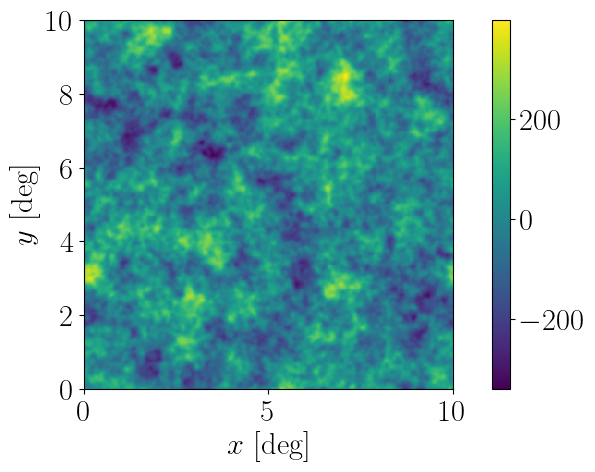

check the power spectrum


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:453: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


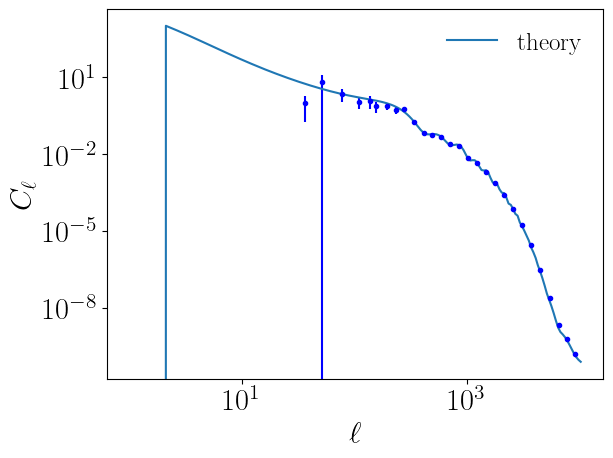

In [7]:
print("Generate GRF unlensed CMB map (debeamed)")

#generate GRF with the same power spectrum as the unlensed CMB
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)
print("plot unlensed CMB map")
baseMap.plot(cmb0)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(cmb0Fourier, theory=[cmb.funlensedTT], plot=True, save=False)

Generate GRF kappa map
plot kappa map


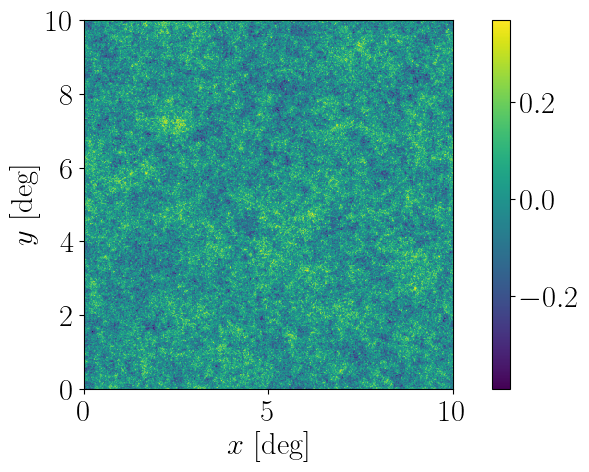

check the power spectrum


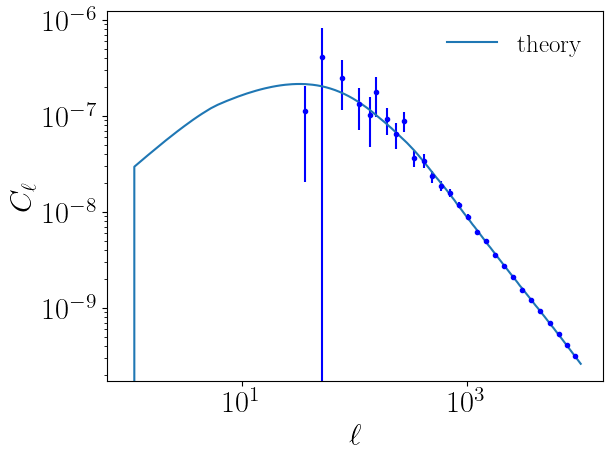

In [8]:
print("Generate GRF kappa map")

kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)
print("plot kappa map")
baseMap.plot(kCmb)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(kCmbFourier, theory=[p2d_cmblens.fPinterp], plot=True, save=False)

Lens the CMB map


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1198: RuntimeWarning: invalid value encountered in divide
  dxFourier = -2.j * self.lx/self.l**2 * kappaFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1199: RuntimeWarning: invalid value encountered in divide
  dyFourier = -2.j * self.ly/self.l**2 * kappaFourier


plot lensed CMB map


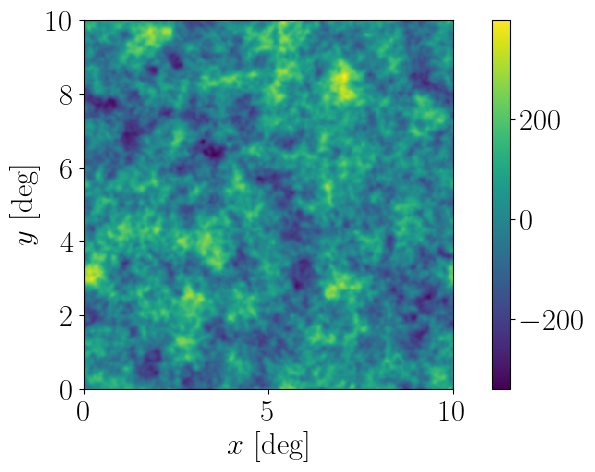

check the power spectrum


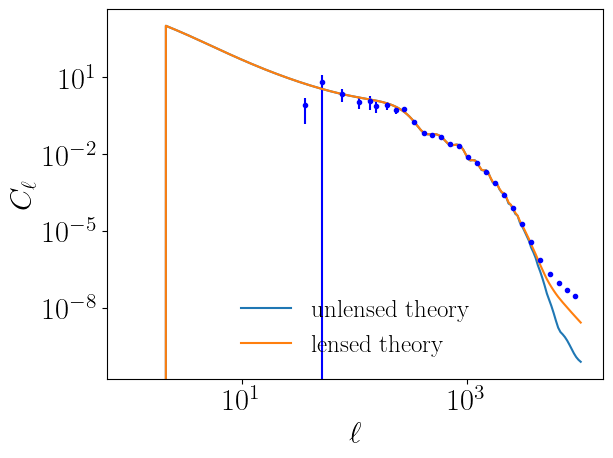

In [9]:
print("Lens the CMB map")

lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)
print("plot lensed CMB map")
baseMap.plot(lensedCmb, save=False)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(lensedCmbFourier, 
                                      theory=[cmb.funlensedTT, cmb.flensedTT], 
                                      theory_l=['unlensed', 'lensed'],
                                      plot=True, save=False)

In [10]:
print("Compute the statistical uncertainty on the reconstructed lensing convergence")

print("- standard quadratic estimator")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

Compute the statistical uncertainty on the reconstructed lensing convergence
- standard quadratic estimator
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1658: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:1658: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


In [11]:

data = {}
Cls = {}
funcs = dict(zip(['standard', 'AFC Eq(7)'], 
                 [baseMap.computeQuadEstKappaNorm, 
                  baseMap.computeQuadEstKappaAutoCorrectionMap]))

for key in funcs:
    data[key] = funcs[key](cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, 
                                                       dataFourier=lensedCmbFourier, test=False)



    Cls[key] = baseMap.powerSpectrum(dataFourier=data[key],
                                          theory=[p2d_cmblens.fPinterp, fNqCmb_fft], 
                                          theory_l=['TODO ask p2d?', 'QE'],
                                          plot=False, save=False)



Doing full calculation: computeQuadEstPhiNormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/delon/Dropbox/research/manu/LensQuEst/LensQuEst/flat_map.py:2336: RuntimeWarning: invalid value encountered in sqrt
  resultFourier = np.sqrt(np.real(resultFourier))


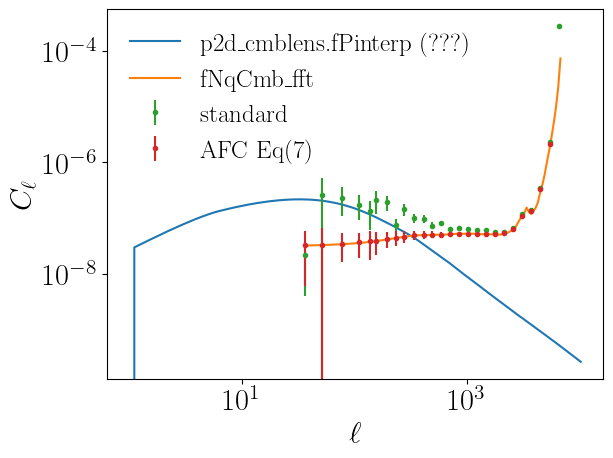

In [12]:
fig, ax = plt.subplots(1)
ell = baseMap.l.flatten()
factor = 1. # lCen**2

theory=[p2d_cmblens.fPinterp, fNqCmb_fft]
theory_l=['p2d_cmblens.fPinterp (???)', 'fNqCmb_fft']
for f,l in zip(theory, theory_l):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, factor*ClExpected, label=l)

for key in Cls:
    lCen, Cl, sCl = Cls[key]
    Ipos = np.where(Cl>=0.)
    Ineg = np.where(Cl<0.)
    ax.errorbar(lCen[Ipos], factor*Cl[Ipos], yerr=factor*sCl[Ipos], fmt='.', label=key)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$C_\ell$')
    
    plt.legend(frameon=False)
plt.savefig('figures/Cl_compare.png', bbox_inches='tight')